In [120]:
import numpy as np
import math, scipy
import mpmath as mp

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.integrate import quad
from scipy import optimize

In [38]:
from astropy.utils.data import download_file
sz_filename = download_file( 'https://astro.ukzn.ac.za/~mjh/ACTDR5/v1.0b3/DR5_cluster-catalog_v1.0b3.fits', cache=True )

In [39]:
sz_list = fits.open(sz_filename, memmap=True)
sz_data = Table(sz_list[1].data)
sz_data

name,RADeg,decDeg,SNR,y_c,err_y_c,fixed_SNR,fixed_y_c,fixed_err_y_c,template,tileName,redshift,redshiftErr,redshiftType,redshiftSource,M500,M500_errPlus,M500_errMinus,M500Cal,M500Cal_errPlus,M500Cal_errMinus,M200m,M200m_errPlus,M200m_errMinus,M500Uncorr,M500Uncorr_errPlus,M500Uncorr_errMinus,M200mUncorr,M200mUncorr_errPlus,M200mUncorr_errMinus,footprint_DESY3,footprint_HSCs19a,footprint_KiDSDR4,zCluster_delta,zCluster_errDelta,zCluster_source,RM,RM_LAMBDA,RM_LAMBDA_ERR,RMDESY3,RMDESY3_LAMBDA_CHISQ,RMDESY3_LAMBDA_CHISQ_E,CAMIRA,CAMIRA_N_mem,opt_RADeg,opt_decDeg,opt_positionSource,notes,knownLens,knownLensRefCode,warnings
str19,float64,float64,float64,float64,float64,float64,float64,float64,str25,str7,float64,float64,str1000,str1000,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,float64,float64,str12,bool,float64,float64,bool,float64,float64,bool,float64,float64,float64,str10,str15,str42,str14,str93
ACT-CL J0000.0-3837,0.02089636940341408,-38.6267289770723,4.801052395993813,0.32624126531723824,0.06795203184815621,4.638507136672629,0.4613009877141266,0.09945031324130604,Arnaud_M4e14_z0p2,1_4_9,0.30059880018234253,0.006646059453487396,phot,redMaPPer,1.6839206865134309,0.4237627400685425,0.3385626300303727,2.405600980733473,0.6514203455857177,0.540182401616195,3.056939631309494,0.7692862999800786,0.6146165491696186,1.8917236169663734,0.49405841289710534,0.39174658713137345,3.4433530332866233,0.8992949706882382,0.7130649461582924,True,False,False,-99.0,-99.0,,False,-99.0,-99.0,True,48.39299011230469,2.8816137313842773,False,-99.0,0.0237755479101338,-38.6267365901279,RMDESY3,,,,
ACT-CL J0000.2-4357,0.0613184665449881,-43.95564541682309,7.676261676126595,0.5937448203845332,0.07734817355576837,7.581173287447871,0.7258456368193705,0.0957431797557182,Arnaud_M1e14_z0p2,1_3_8,0.8781313300132751,0.013949314132332802,phot,redMaPPer,2.4372534289564993,0.43003741028682374,0.3655402299815897,3.4817906127949994,0.7061453527538921,0.6276319318247866,4.152462371437393,0.7326747983245081,0.6227879432689942,2.68204368032856,0.4884735155976706,0.4132156441857253,4.578865893551085,0.8339367240279881,0.7054542152766037,True,False,False,5.927447554118249,0.79,DECaLS,False,-99.0,-99.0,True,27.53944206237793,4.8247599601745605,False,-99.0,0.0715174930557,-43.9575927455,Vis-BCG,,,,
ACT-CL J0000.3-2805,0.08990472178653934,-28.09125525860719,5.655514747807726,0.6755728100936604,0.1194538145896509,4.649275735635169,0.8850568965301341,0.19036446682360955,Arnaud_M8e14_z0p2,1_5_9,0.28257,0.0,spec,PublicSpec,2.7005743947278456,0.6982766597726844,0.554819272036419,3.8579634210397797,1.0695424486122358,0.8815054900886125,4.983699949581323,1.2886152519614789,1.0238758034115554,3.1250033342052914,0.8488507954563725,0.6675286710309793,5.787618817420814,1.57210227048135,1.2362871601893162,False,False,True,-99.0,-99.0,,False,-99.0,-99.0,False,-99.0,-99.0,False,-99.0,0.0969564225612,-28.1034876567,Vis-BCG,,,,
ACT-CL J0000.4-0102,0.11353645092886261,-1.0448048370218106,4.968499403523599,0.29346516344873225,0.05906515018208724,4.4264242493544295,0.370215047644781,0.08363749762548742,Arnaud_M8e14_z0p2,1_11_7,0.4388004,0.0,spec,PublicSpec,1.4937930311776006,0.36564597975460783,0.29374419554728987,2.1339900445394298,0.5642606842742659,0.4707784014813888,2.6189757146686397,0.6410646730548882,0.5150036841829149,1.6746705880160941,0.4243234311809947,0.33854406611254423,2.943284681193229,0.7457613836437478,0.5950015309448686,True,False,False,5.562984119794632,0.39,DECaLS,True,51.352455139160156,6.968789100646973,True,64.76158142089844,3.7263598442077637,False,-99.0,0.11600127049860674,-1.0430399151302663,Vis-BCG,,,,
ACT-CL J0000.4-0552,0.1139783988889742,-5.880625657418912,4.58304201793786,1.0676234462083356,0.23295083091747712,4.309756440893817,0.46633060601446374,0.10820347098727223,Arnaud_M1e14_z1p2,1_10_7,0.2017347,0.0,spec,PublicSpec,1.6235775867110362,0.46820263155048314,0.36340495621297

### Figure 16
From Hilton et al 2020: "The left panel of Fig. 16 summarizes the contents of the catalog by showing the distribution of the clusters in terms of co-moving coordinates in the celestial equatorial plane (i.e., right ascension is used as the angular coordinate). The right panel of Fig. 16 shows a similar plot but in spherical polar coordinates." (page 20)

Caption: "Figure 16. The left panel displays a wedge plot showing the contents of the ACT DR5 cluster catalog, drawn in the equatorial plane. Right Ascension is used as the angular coordinate, with 0◦ RA pointing to the right from the origin, and increasing anticlockwise. The radial coordinate is co-moving distance in Mpc. Each point represents a cluster in the catalog, with the size of each point scaling with cluster mass. The dashed circles mark the distances equivalent to redshifts 0.5, 1.0, 1.5, and 2.0, starting from the observer’s location at (0, 0). The larger number of clusters seen on the right of the plot compared to the left reflects the fact that ACT surveyed much more sky area at those RA coordinates (see Fig. 1)." (page 22)

In [40]:
#Convert from redshift, z, to co-moving distance, D_c.

def rsToDc(z): 
    omega_m = 0.3
    omega_r = 0.0
    omega_a = 0.7
    d_h = 3E5/70  # h^-1 Mpc #The distance that the speed of light would have traveled at the start of the universe.
    e_z = lambda z: 1.0/(np.sqrt(omega_m*(1+z)**3+omega_r*(1+z)**2+omega_a))
    integral, error = quad(e_z, 0.0, z) #returns the result and the error in a tuple
    return d_h * integral

#Create an array of co-moving distances

dcomov_array = np.empty(len(sz_data['redshift']), dtype=object)
for i in range(len(dcomov_array)):
	dcomov_array[i] = rsToDc(sz_data['redshift'][i])

dcomov_array

array([1197.4246656901705, 2998.6569111311296, 1130.8350958856915, ...,
       3816.9530208257597, 2720.630906401806, 2466.5763841785797],
      dtype=object)

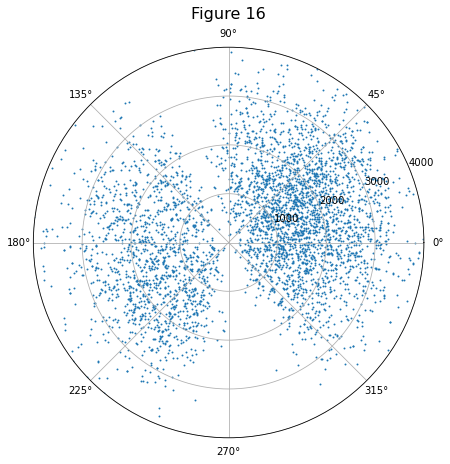

In [211]:
fig16 = plt.figure(figsize = (7,9)) ## initialize a matplotlib figure

fig16 = plt.subplot(111, projection='polar')

fig16.set_rlim(0,4000)
fig16.set_rticks([1000, 2000, 3000, 4000])  # radial ticks
fig16.scatter((sz_data['RADeg']*(np.pi/180)), dcomov_array, s = 0.85) #convert from degrees to radians

# Aesthetic and Label Parameters for Matplotlib.
#plt.label('Comoving Distance (Mpc)')
#plt.ylabel('Comoving Distance (Mpc)')
fig16.set_title("Figure 16", va='bottom', fontsize = 16)

#plt.savefig('Cluster-Distribution_KD.png', bbox_inches='tight')

plt.show()

### Figure 18

From Hilton et al 2020 caption: "Figure 18. Comparison of the ACT DR5 cluster sample in the (mass, redshift) plane with other blind SZ surveys: PSZ2 (Planck Collaboration et al. 2016b), SPT-SZ (Bocquet et al. 2019), SPT-ECS (Bleem et al. 2020), and SPTpol (Huang et al. 2020a). The large blue points show the ACT DR5 sample selected with SNR2.4 > 5, which is similar to the detection thresholds used in the other surveys. The small blue points extend this to include the full ACT DR5 sample. The ACT DR5 SZ masses displayed here have been rescaled according to a richness-based weak-lensing mass calibration, which is a close match to the SPT mass scale (see Section 5.1). Mass measurements from the SPT surveys and PSZ2 are as reported in the respective catalogs. The ACT DR5 sample has been plotted behind the other surveys to aid clarity." (page 22)

y axis: "M500c in units of 10^14 M, rescaled using the richness-based weak-lensing mass calibration factor of 0.70 ± 0.07 (see Section 4.1). Uncertainty column(s): M500Cal errPlus, M500Cal errMinus." (page 5)

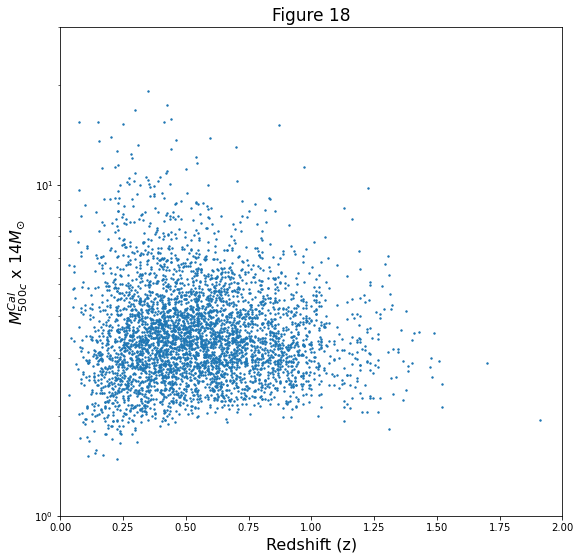

In [213]:
fig18 = plt.figure(figsize = (9,9)) ## initialize a matplotlib figure

plt.scatter(sz_data['redshift'], sz_data['M500Cal'], s = 2)

plt.xlim(0,2.0)
plt.ylim(10**0, 30)
plt.yscale('log')

plt.xlabel('Redshift (z)', fontsize = 16)
plt.ylabel('$M^{Cal}_{500c}$ x ${14}M_{\odot}$', fontsize = 16)
plt.title('Figure 18', fontsize = 17)

#plt.savefig('ACT-Sample-Comparison_KD', bbox_inches='tight')

plt.show()



### Plot of the spectral distortion of the CMB due to the SZ effect. 
Take y=1.

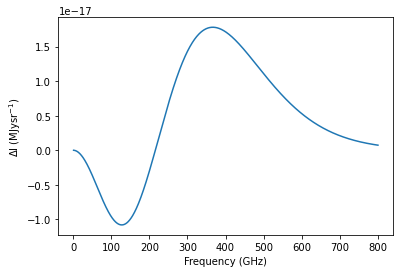

In [214]:
#plt.xlim(1.0,800.0)

def funcI(nu): #Change of intensity divided by initial intensity, Plank spectrum
    x = (6.626E-34*nu)/(1.381E-23*2.7)
    a = (x*np.exp(x))/(np.exp(x)-1)
    g = a*((x/np.tanh(x/2.))-4)*((2*6.626E-34*nu**3)/(3E8**2))*(1/(np.exp(x)-1))
    return g
                  
x_vals=np.linspace(1E9,800E9,1000)
fx_vals = np.empty(len(x_vals))

for i in range(len(x_vals)): 
    fx_vals[i] = funcI(x_vals[i])
                  
plt.figure()
plt.plot(x_vals/1.E9,fx_vals)
plt.xlabel('Frequency (GHz)')
plt.ylabel('$\Delta$I (MJysr$^{-1}$)')

#plt.savefig('Spectral-Distortion_KD', bbox_inches='tight')

plt.show()


### Plot the comoving volume element of the Halo Mass Function
From z = 0 to z =3
Fit a power law to the mass function



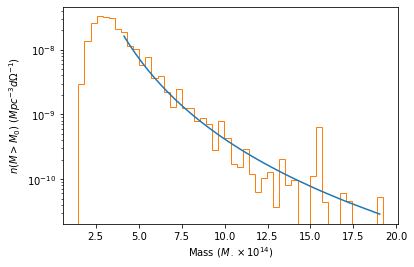

In [217]:
masses_array = sz_data['M500Cal']
redshift_array = sz_data['redshift']
    
def E(z):
    omega_m = 0.3
    omega_k = 0.0
    omega_L = 0.7
    result = np.sqrt(omega_m * (1+z)**3+omega_k*(1+z)**2+omega_L)
    return result

def cmvol_element(z):
    hub_dist = 3000. #h^-1 Mpc
    frac = (rsToDc(z)**2/E(z))
    return hub_dist*frac

cmvol_array = np.empty(len(redshift_array))
for i in range(len(redshift_array)): 
    cmvol_array[i] = cmvol_element((redshift_array[i])/(0.7)**3)

# Fitting to power law -- attempt 2

# Histogram in array form, with separate variable for bins
histdata, bins = np.histogram(masses_array, weights = 1/cmvol_array, bins=50)

# Independent variable is log of midpoint of bins (purpose?)
midpoints = np.empty(len(bins)-1) 
for i in range(len(bins)-1):
    midpoints[i] = (bins[i]+bins[i+1])/2.
    
loghist = np.log10(histdata[np.where(histdata!=0)]) # Faster version of an 'if' statement used to eliminate log(0)
# Multiply each midpoint by 10^14 solar masses 
# np.array obviates for loop
logmass = np.log10((10**14)*np.array(midpoints)[np.where(histdata!=0)]) 

# We want to focus the fit to larger masses because they are less likely to experience survey bias. 
# Figure 7 in the catalog paper indicates that the dataset reaches ~90% at masses >~14.6, so we will cut off the masses below 14.6.
masscut = 14.6 # In log units

loghist_cut = loghist[np.where(logmass>masscut)] 
logmass_cut = logmass[np.where(logmass>masscut)]

def chisquare(x,mass,hist): # All these inputs are arrays
    m = x[0] # Fit parameter 1
    b = x[1] # Fit parameter 2
    b_array = b*np.ones(len(mass))
    model = m*mass+b_array # Calculate fit model (?)
    resids = hist-model # Hist is an argument. Residual means the difference between the actual data and the model's prediction. 
    chisquared = np.sqrt(np.mean(resids*resids)) # Chi squared is the square root of the average of the residuals array-squared
    return chisquared

x0 = [-1., -7.5] # Initial guess array (?)
results = optimize.minimize(chisquare, x0, args=(logmass_cut, loghist_cut))
xfit = results.x

def linearmodel(x,mass): # Make an array using the fit parameters
    m = x[0]
    b = x[1]
    b_array = b*np.ones(len(mass))
    model = m*mass+b_array
    return model 

plt.figure()
plt.plot((10**logmass_cut)/10**14, 10**linearmodel(xfit, logmass_cut)) # 10^linear-model to reverse the log 
plt.hist(masses_array, weights = 1/cmvol_array, bins = 50, histtype='step', density=False, log=True)

plt.xlabel(r'Mass $(M_\cdot \times 10^{14})$')
plt.ylabel(r'$n(M>M_0)$ ($Mpc^{-3}d\Omega^{-1}$)')

plt.savefig('Halo-Mass-Function_KD.png', bbox_inches='tight')

plt.show()    